In [33]:
import sys
sys.path.append('..')
from src.analyse_utils_keras import plot_history
from src.model_utils_keras import load_model_history
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import backend as K
import cv2

In [2]:
vanilla_sgd_model, vanilla_sgd_history = load_model_history('vanilla_sgd_keras')
vanilla_adam_model, vanilla_adam_history = load_model_history('vanilla_adam_keras')
resnet1_model, resnet1_history = load_model_history('resnet_keras')
resnet2_model, resnet2_history = load_model_history('resnet_keras2')
densenet1_model, densenet1_history = load_model_history('densenet_keras')
densenet2_model, densenet2_history = load_model_history('densenet_keras2')

/home/cugtyt/software/miniconda3/lib/python3.6/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [3]:
vanilla_sgd_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 63, 63, 64)        36928     
__________

# Visualizing intermediate activations

In [4]:
image_path = '../../data/Asian/AF0301_1100_00F.jpg'

img = image.load_img(image_path, target_size=(128, 128))
img_tensor = np.expand_dims(image.img_to_array(img), axis=0) / 255

print(img_tensor.shape)

(1, 128, 128, 3)


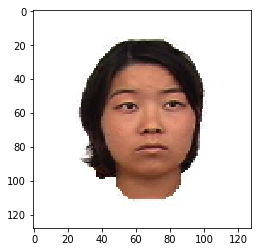

In [5]:
plt.imshow(img_tensor[0])

In [36]:
layer_outputs = [layer.output for layer in vanilla_sgd_model.layers[:10]]
activation_model = models.Model(inputs=vanilla_sgd_model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

In [37]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 128, 128, 32)


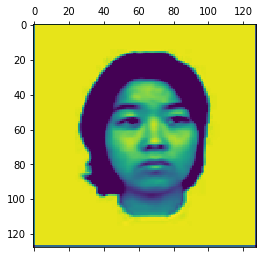

In [38]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

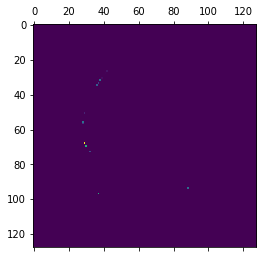

In [39]:
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

In [50]:
def visual_activations(model, layer_range):
    layer_outputs = [layer.output for layer in model.layers[layer_range]]
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    activations = activation_model.predict(img_tensor)

    layer_names = []
    for layer in model.layers[layer_range]:
        layer_names.append(layer.name)

    images_per_row = 16

    for layer_names, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]
        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image

        scale = 1 / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_names)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

/home/cugtyt/software/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


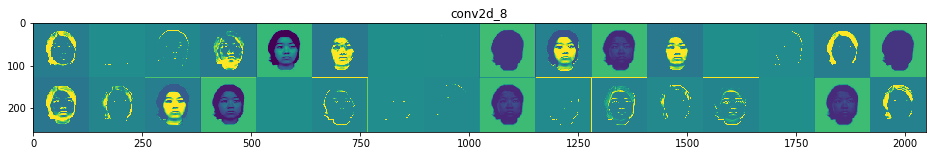

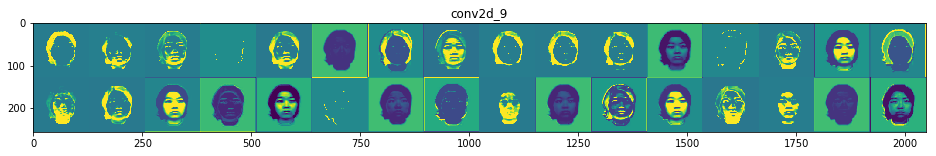

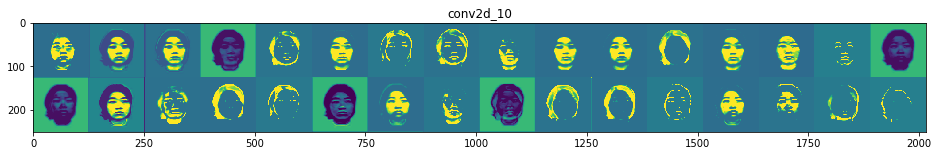

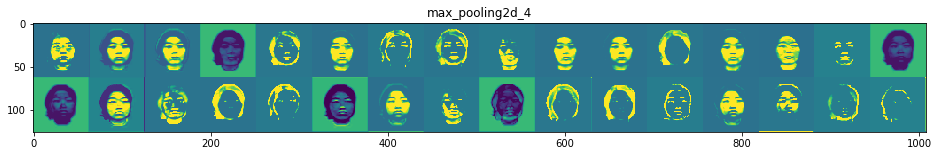

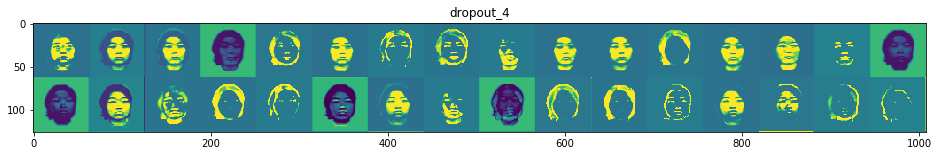

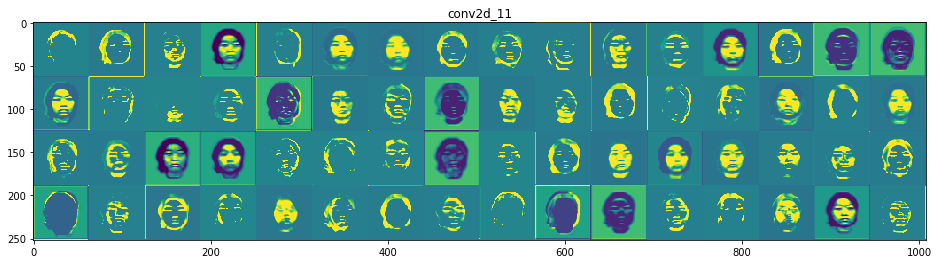

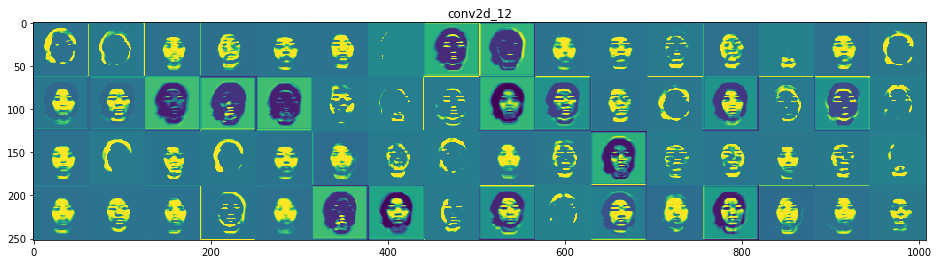

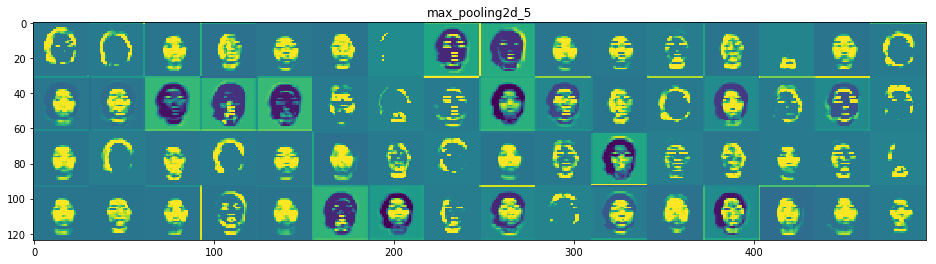

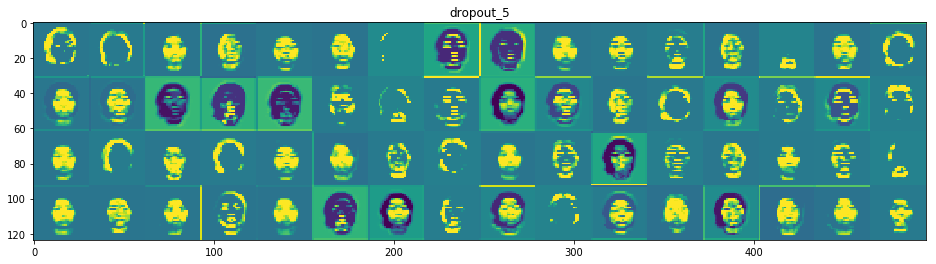

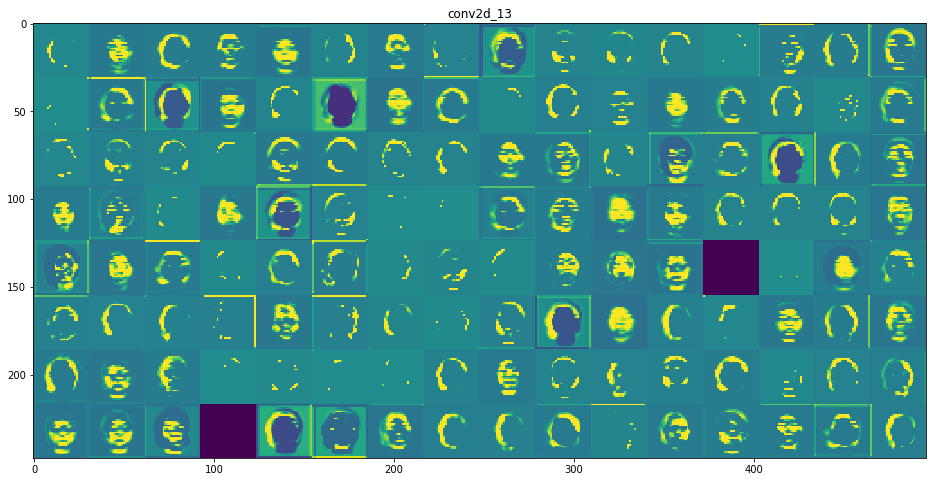

In [52]:
visual_activations(vanilla_sgd_model, slice(10))

/home/cugtyt/software/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


MemoryError: 

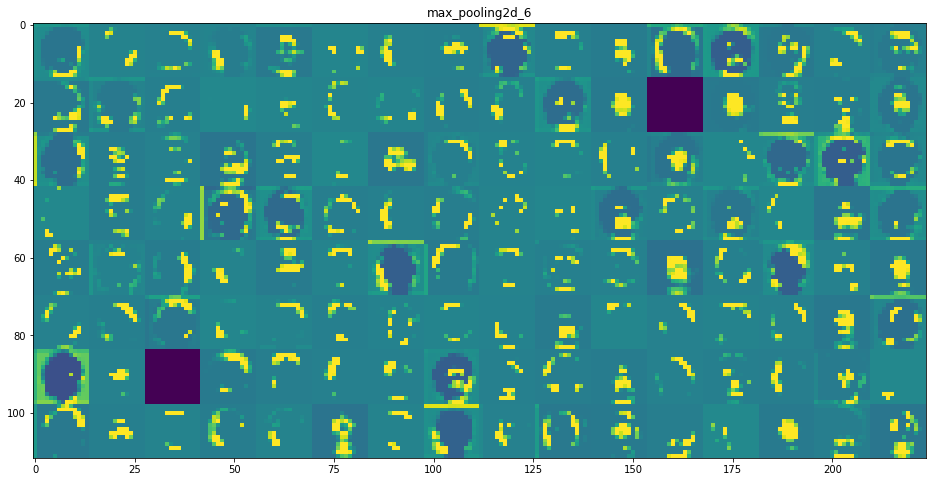

In [56]:
visual_activations(vanilla_sgd_model, slice(11, 13))

# Visualizing convnet filters

In [13]:
def deprocess_image(x):
    x -= x.mean()
    x /= x.std() + 1e-5
    x *= 0.1
    x+= 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [14]:
def generate_pattern(model, layer_name, filter_index, size=128):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= K.sqrt(K.mean(K.square(grads))) + 1e-5
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

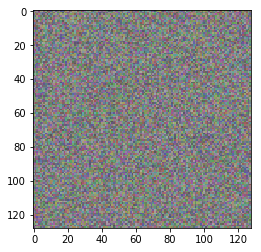

In [71]:
plt.imshow(generate_pattern(vanilla_sgd_model, 'conv2d_14', 80))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


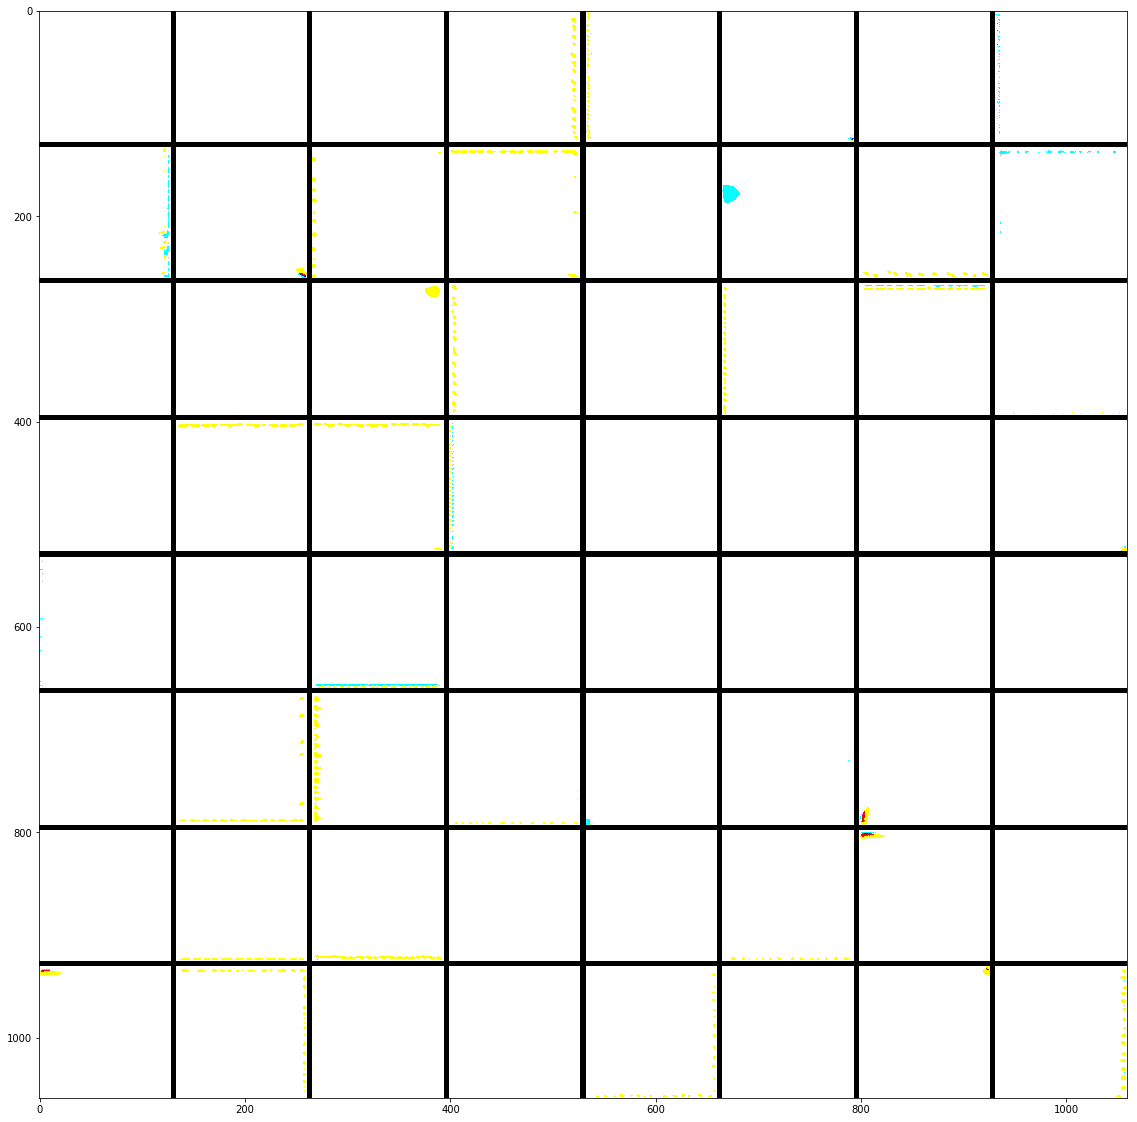

In [59]:
# layer_names = []
# for layer in vanilla_sgd_model.layers[:8]:
#     layer_names.append(layer.name)
    
layer_name = 'conv2d_11'
size = 128
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(vanilla_sgd_model, layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
        
plt.figure(figsize=(20, 20))
plt.imshow(results)

# Visualizing heatmaps of class activation

In [76]:
preds = vanilla_sgd_model.predict(img_tensor)

In [77]:
np.argmax(preds[0])

0

In [81]:
face_output = vanilla_sgd_model.output[:, 2]
last_conv_layer = vanilla_sgd_model.get_layer('conv2d_13')
grads = K.gradients(face_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([vanilla_sgd_model.input], [pooled_grads, last_conv_layer.output[0]])
pooles_grads_value, conv_layer_output_value = iterate([img_tensor])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooles_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

IndexError: index 128 is out of bounds for axis 2 with size 128